<a href="https://colab.research.google.com/github/plv02b107/ds_pallvi/blob/main/ReturnStratergy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

In [ ]:
df = yf.download("AAPL", start="2018-01-01", end="2025-01-01", progress=False)

/tmp/ipython-input-2080276160.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("AAPL", start="2018-01-01", end="2025-01-01", progress=False)


Use volume change as proxy for market attention/sentiment

In [ ]:
df['vol_change'] = df['Volume'].pct_change()
df['vol_avg'] = df['vol_change'].rolling(12, min_periods=5).mean()
df['vol_ffill'] = df['vol_avg'].ffill(limit=504)

Compute daily returns

In [ ]:
df['returns'] = df['Close'].pct_change()
df = df.dropna().copy()

Signal = True if either (volume trend > 0) OR (returns < 0)

In [ ]:
df['signal'] = (df['vol_ffill'] > 0) | (df['returns'] < 0)
df['signal_numeric'] = df['signal'].astype(int).replace({0: -1})

In [ ]:
df['strategy_return'] = df['signal_numeric'].shift(1) * df['returns']
df['cum_strategy'] = (1 + df['strategy_return']).cumprod()
df['cum_market'] = (1 + df['returns']).cumprod()

Evaluation

In [21]:
accuracy = (np.sign(df['strategy_return']) == np.sign(df['returns'])).mean() * 100
sharpe = df['strategy_return'].mean() / df['strategy_return'].std() * np.sqrt(252)
print(f"Prediction Accuracy: {accuracy:.2f}%")
print(f"Sharpe Ratio: {sharpe:.2f}")


Prediction Accuracy: 88.95%
Sharpe Ratio: 1.05


Equity Curve

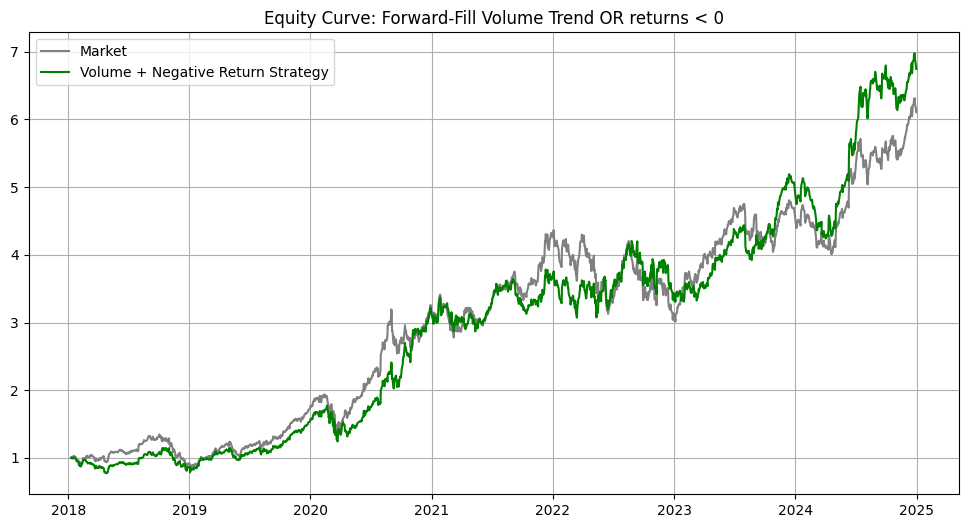

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['cum_market'], label='Market', color='gray')
plt.plot(df.index, df['cum_strategy'], label='Volume + Negative Return Strategy', color='green')
plt.title("Equity Curve: Forward-Fill Volume Trend OR returns < 0")
plt.legend()
plt.grid(True)
plt.show()